### Create statistical features for channel 1

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
import joblib

In [3]:
# reading data
channel_1_csv_path = "channel_1_data.csv"
if not os.path.exists(channel_1_csv_path):
    raise FileNotFoundError(f"File not found: {channel_1_csv_path}")

channel_1_data = pd.read_csv(channel_1_csv_path, header=None).values.flatten()

print(f"Channel 1 data loaded, shape: {channel_1_data.shape}")

Channel 1 data loaded, shape: (20152320,)


In [4]:
# define sliding window function
def sliding_window(data, window_size, stride):
    windows = []
    start_idx = 0
    while start_idx + window_size <= len(data):
        windows.append(data[start_idx:start_idx + window_size])
        start_idx += stride
    return np.array(windows)


window_size = 512
stride = 256
channel_1_windows = sliding_window(channel_1_data, window_size, stride)

print(f"Data shape after applying slide window: {channel_1_windows.shape}")

Data shape after applying slide window: (78719, 512)


In [5]:
# define statistical features
def extract_features(windows):
    return np.column_stack([
        np.mean(windows, axis=1),
        np.std(windows, axis=1), # std
        np.max(windows, axis=1), # max
        np.min(windows, axis=1), # min
        kurtosis(windows, axis=1), # kurtosis plot
        skew(windows, axis=1),
        np.sqrt(np.mean(windows**2, axis=1)),  # RMS values
        np.ptp(windows, axis=1),  # amplitude range
        np.max(windows, axis=1) / (np.sqrt(np.mean(windows**2, axis=1)) + 1e-10),  # peak factor
        np.sum(np.diff(np.sign(windows), axis=1) != 0, axis=1)  # zero-crossing rate
    ])
    
# get features
features = extract_features(channel_1_windows)

# normalization of features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Save the scaler
joblib.dump(scaler, "scaler_nasa.pkl")

# check the shape of feature matrix
print(f"Feature matrix shape: {features.shape}")

Feature matrix shape: (78719, 10)


In [6]:
# save channel 1 features to csv file
feature_csv_path = "channel_1_features.csv"
np.savetxt(feature_csv_path, features, delimiter=",", 
           header="Mean,Std,Max,Min,Kurtosis,Skewness,RMS,AmplitudeRange,PeakFactor,ZeroCrossings", comments="")

print(f"Feature matrix saved as CSV file at: {feature_csv_path}")


Feature matrix saved as CSV file at: channel_1_features.csv


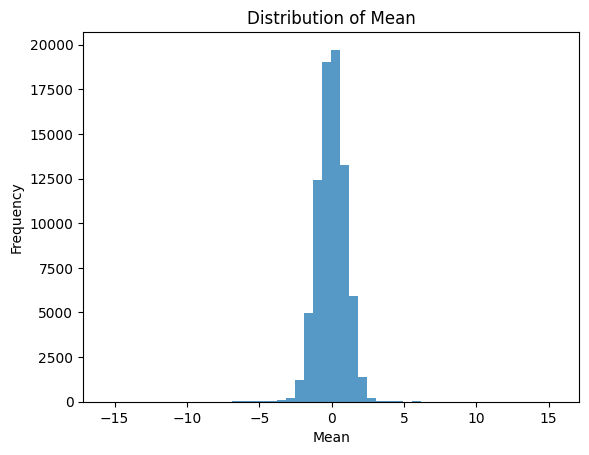

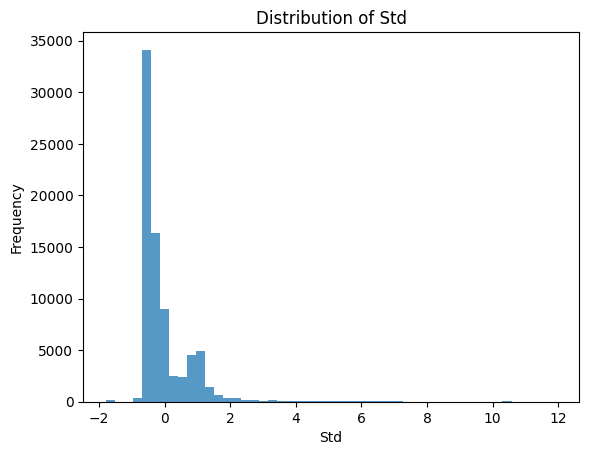

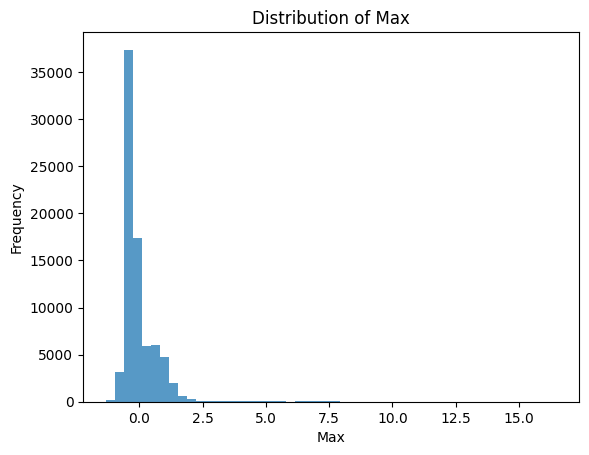

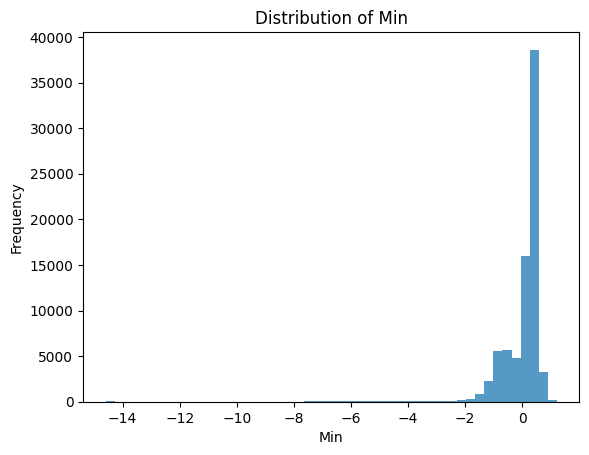

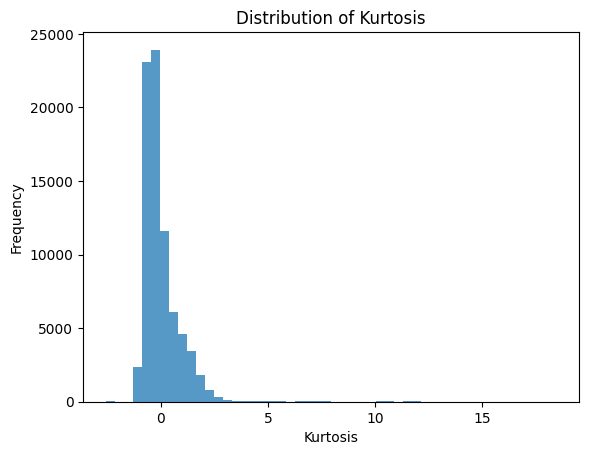

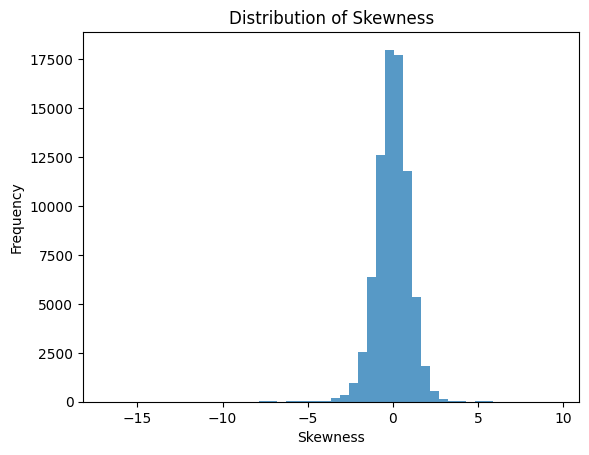

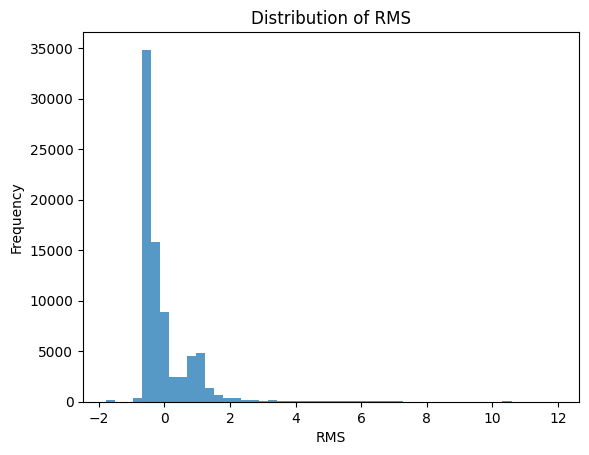

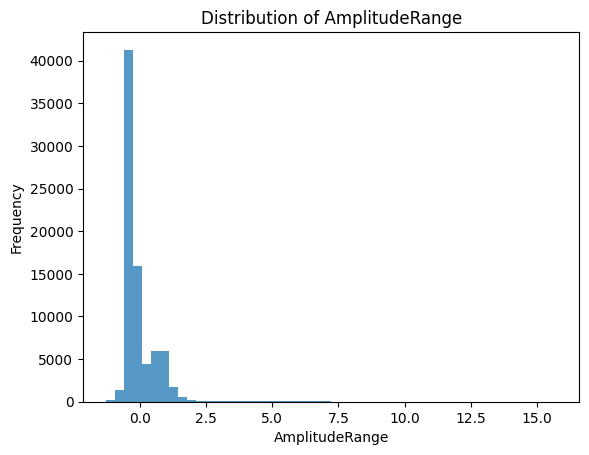

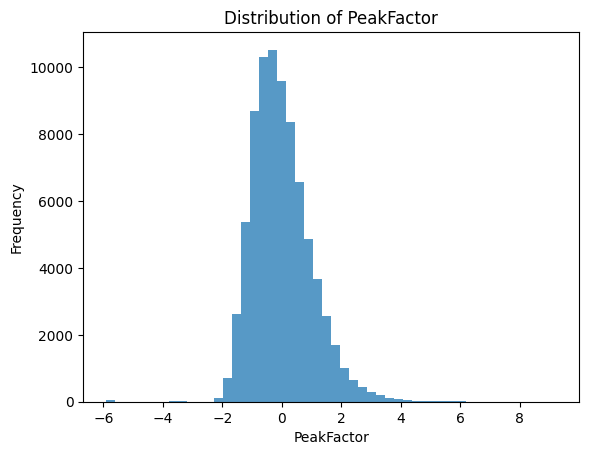

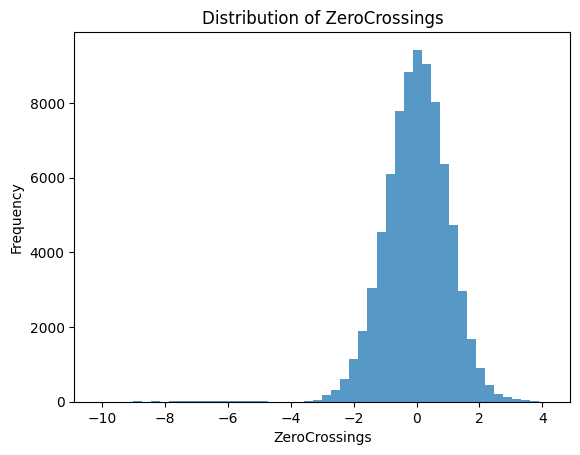

In [7]:
# plot statistical features
feature_names = ["Mean", "Std", "Max", "Min", "Kurtosis", "Skewness", "RMS", "AmplitudeRange", "PeakFactor", "ZeroCrossings"]
for i, feature in enumerate(features.T):
    plt.hist(feature, bins=50, alpha=0.75)
    plt.title(f"Distribution of {feature_names[i]}")
    plt.xlabel(feature_names[i])
    plt.ylabel("Frequency")
    plt.show()